# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [50]:
# comment this out if you're not on a  multi-gpu config
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [51]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

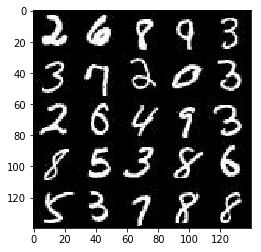

In [52]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

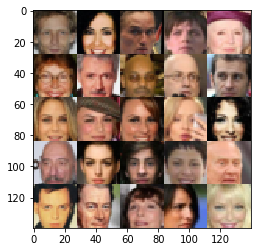

In [53]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data, learning_rate placeholder)

In [55]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels])
    z_input_ = tf.placeholder(dtype=tf.float32, shape=[None, z_dim])
    lr_ = tf.placeholder(dtype=tf.float32, shape=None)
    
    return input_, z_input_, lr_


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [56]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.maximum(conv1, conv1 * alpha)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(conv2, conv2 * alpha)

        flat = tf.reshape(conv2,  shape=[-1,128*7*7])
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        #logits = tf.layers.dropout(logits, 0.5)
        output = tf.nn.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [76]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        layer0 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer0 = tf.reshape(layer0, [-1, 7, 7, 512])
        layer0 = tf.layers.batch_normalization(layer0, training=is_train)
        layer0 = tf.maximum(layer0, alpha*layer0)
        
        conv1 = tf.layers.conv2d_transpose(layer0, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(conv1, conv1 * alpha)
        
        conv2 = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())

        output = tf.nn.tanh(conv2)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [77]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
   
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [78]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    tf_vars = tf.trainable_variables()
    
    d_vars = [var for var in tf_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in tf_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [79]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [80]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 1 if data_image_mode == "L" else 3
    input_real, input_z, lr_ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_train, g_train = model_opt(d_loss, g_loss, lr_, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for step, batch_images in enumerate(get_batches(batch_size)):
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _, _ = sess.run([d_train, g_train], feed_dict={input_real:batch_images, input_z:batch_z, lr_:learning_rate})
                sess.run(g_train, feed_dict={input_real:batch_images, input_z:batch_z, lr_:learning_rate})
                #sess.run(g_train, feed_dict={input_real:batch_images, input_z:batch_z, lr_:learning_rate})
                if step % 50 == 0:
                    d_loss_var, g_loss_var = sess.run([d_loss, g_loss], feed_dict={input_real:batch_images, input_z:batch_z})
                    print("Epoch {}: Step:{} d_loss:{} g_loss:{}".format(epoch_i, step, d_loss_var, g_loss_var))
                if step%150 ==0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
            #print("Epoch Finished with Generator Loss at {} and D Loss at {}".format())
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0: Step:0 d_loss:7.300415515899658 g_loss:0.003038965631276369


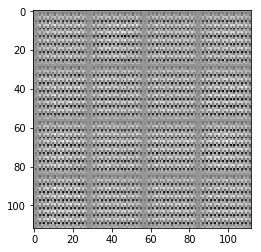

Epoch 0: Step:50 d_loss:2.49920392036438 g_loss:0.31873512268066406
Epoch 0: Step:100 d_loss:2.1705782413482666 g_loss:0.3969326615333557
Epoch 0: Step:150 d_loss:1.6395506858825684 g_loss:0.4930577278137207


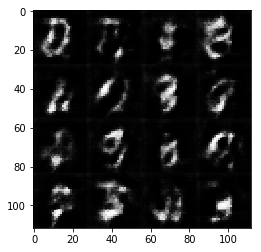

Epoch 0: Step:200 d_loss:1.8663138151168823 g_loss:0.3734574019908905
Epoch 0: Step:250 d_loss:1.6159663200378418 g_loss:0.7689821720123291
Epoch 0: Step:300 d_loss:1.6897166967391968 g_loss:0.47289103269577026


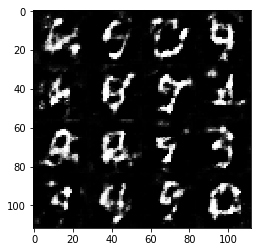

Epoch 0: Step:350 d_loss:1.6228231191635132 g_loss:1.1394819021224976
Epoch 0: Step:400 d_loss:1.714269995689392 g_loss:0.41186338663101196
Epoch 0: Step:450 d_loss:1.6556510925292969 g_loss:0.5670962333679199


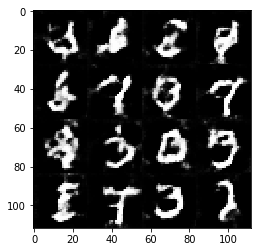

Epoch 0: Step:500 d_loss:1.5565905570983887 g_loss:0.8318344950675964
Epoch 0: Step:550 d_loss:1.4374051094055176 g_loss:0.6660525798797607
Epoch 0: Step:600 d_loss:1.3494912385940552 g_loss:0.8694525957107544


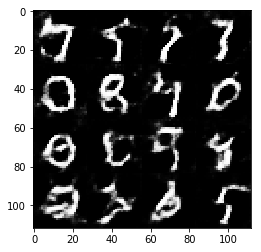

Epoch 0: Step:650 d_loss:1.5566147565841675 g_loss:0.5506246089935303
Epoch 0: Step:700 d_loss:1.5092689990997314 g_loss:0.6180225610733032
Epoch 0: Step:750 d_loss:1.4755558967590332 g_loss:0.8307510614395142


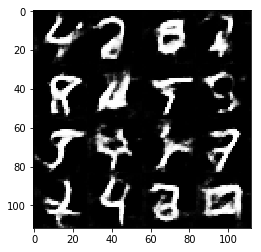

Epoch 0: Step:800 d_loss:1.7555623054504395 g_loss:0.348008930683136
Epoch 0: Step:850 d_loss:1.5527803897857666 g_loss:0.502519965171814
Epoch 0: Step:900 d_loss:1.565745234489441 g_loss:0.522348940372467


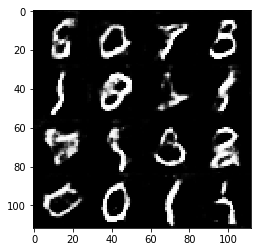

Epoch 0: Step:950 d_loss:1.7029885053634644 g_loss:0.4433239996433258
Epoch 0: Step:1000 d_loss:1.2860766649246216 g_loss:1.2269513607025146
Epoch 0: Step:1050 d_loss:1.4257586002349854 g_loss:0.9229406118392944


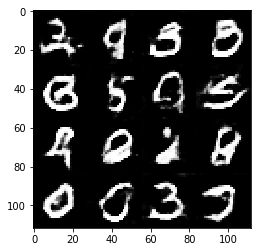

Epoch 0: Step:1100 d_loss:1.4558844566345215 g_loss:0.7060673236846924
Epoch 0: Step:1150 d_loss:1.5792961120605469 g_loss:0.8647646903991699
Epoch 0: Step:1200 d_loss:1.6328246593475342 g_loss:0.49137479066848755


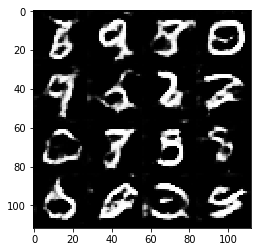

Epoch 0: Step:1250 d_loss:1.4522221088409424 g_loss:0.5354640483856201
Epoch 0: Step:1300 d_loss:1.553828477859497 g_loss:0.4377616047859192
Epoch 0: Step:1350 d_loss:1.814965844154358 g_loss:0.39678025245666504


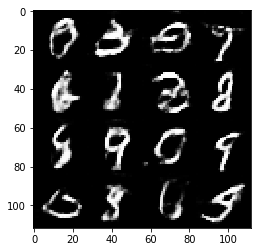

Epoch 0: Step:1400 d_loss:1.4100631475448608 g_loss:0.6566928625106812
Epoch 0: Step:1450 d_loss:1.5115907192230225 g_loss:0.5065985918045044
Epoch 0: Step:1500 d_loss:1.7528992891311646 g_loss:1.9558613300323486


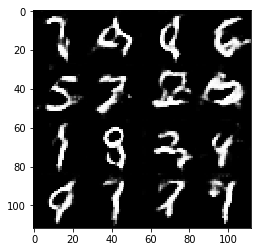

Epoch 0: Step:1550 d_loss:1.3334743976593018 g_loss:0.7410092353820801
Epoch 0: Step:1600 d_loss:1.6103310585021973 g_loss:0.40984368324279785
Epoch 0: Step:1650 d_loss:1.4271515607833862 g_loss:0.6520302295684814


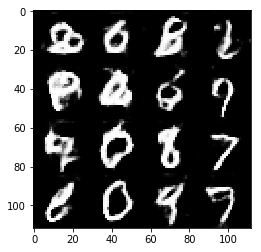

Epoch 0: Step:1700 d_loss:1.394399642944336 g_loss:0.7129079103469849
Epoch 0: Step:1750 d_loss:1.4300086498260498 g_loss:0.5608933568000793
Epoch 0: Step:1800 d_loss:1.4864577054977417 g_loss:0.6042517423629761


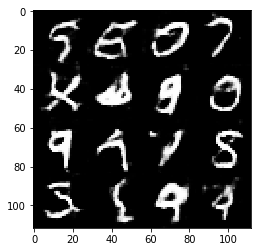

Epoch 0: Step:1850 d_loss:1.3456813097000122 g_loss:0.7924156188964844
Epoch 1: Step:0 d_loss:1.3834969997406006 g_loss:1.138892412185669


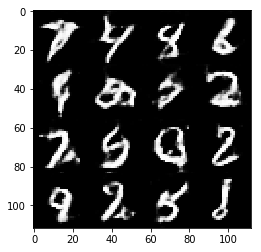

Epoch 1: Step:50 d_loss:1.6423406600952148 g_loss:0.440765917301178
Epoch 1: Step:100 d_loss:1.4543614387512207 g_loss:0.9013192057609558
Epoch 1: Step:150 d_loss:1.4378024339675903 g_loss:0.5595306754112244


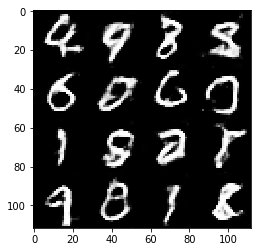

Epoch 1: Step:200 d_loss:1.4223623275756836 g_loss:0.6664490699768066
Epoch 1: Step:250 d_loss:1.6034525632858276 g_loss:1.8676602840423584
Epoch 1: Step:300 d_loss:1.5359995365142822 g_loss:0.41602709889411926


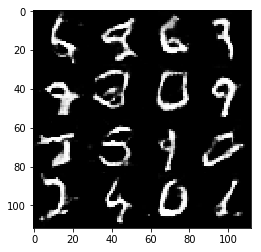

Epoch 1: Step:350 d_loss:1.884195327758789 g_loss:0.2841067314147949
Epoch 1: Step:400 d_loss:1.6450068950653076 g_loss:0.4030230939388275
Epoch 1: Step:450 d_loss:1.4127801656723022 g_loss:0.5547839403152466


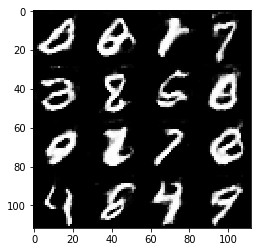

Epoch 1: Step:500 d_loss:2.4138875007629395 g_loss:3.072197437286377
Epoch 1: Step:550 d_loss:1.7597028017044067 g_loss:0.3380349576473236
Epoch 1: Step:600 d_loss:1.3499481678009033 g_loss:1.1645829677581787


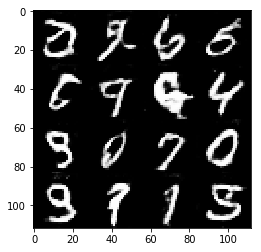

Epoch 1: Step:650 d_loss:1.6282908916473389 g_loss:0.4150751233100891
Epoch 1: Step:700 d_loss:1.7254858016967773 g_loss:0.3503110706806183
Epoch 1: Step:750 d_loss:1.316372275352478 g_loss:0.5967209339141846


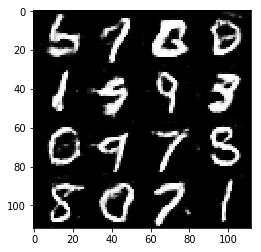

Epoch 1: Step:800 d_loss:1.5657421350479126 g_loss:0.5522986650466919
Epoch 1: Step:850 d_loss:1.4415922164916992 g_loss:0.6009229421615601
Epoch 1: Step:900 d_loss:1.4620466232299805 g_loss:0.49787724018096924


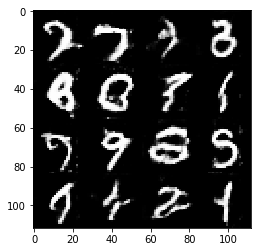

Epoch 1: Step:950 d_loss:1.4189140796661377 g_loss:0.6294765472412109
Epoch 1: Step:1000 d_loss:1.7322434186935425 g_loss:0.36145997047424316
Epoch 1: Step:1050 d_loss:1.7830357551574707 g_loss:1.2349730730056763


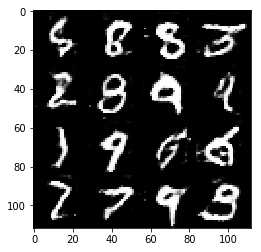

Epoch 1: Step:1100 d_loss:1.2925231456756592 g_loss:0.7424123287200928
Epoch 1: Step:1150 d_loss:1.2785958051681519 g_loss:1.1760847568511963
Epoch 1: Step:1200 d_loss:1.5119223594665527 g_loss:1.5361783504486084


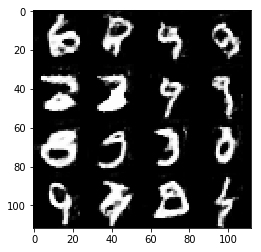

Epoch 1: Step:1250 d_loss:1.5612120628356934 g_loss:0.442268431186676
Epoch 1: Step:1300 d_loss:1.9390703439712524 g_loss:0.27241799235343933
Epoch 1: Step:1350 d_loss:1.6555418968200684 g_loss:0.35281962156295776


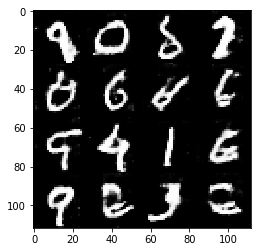

Epoch 1: Step:1400 d_loss:1.3795312643051147 g_loss:0.609115719795227
Epoch 1: Step:1450 d_loss:1.2584681510925293 g_loss:0.7121919393539429
Epoch 1: Step:1500 d_loss:1.1410231590270996 g_loss:1.1719038486480713


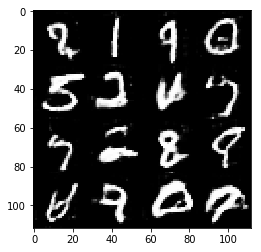

Epoch 1: Step:1550 d_loss:1.375969409942627 g_loss:0.5176922082901001
Epoch 1: Step:1600 d_loss:1.2021104097366333 g_loss:1.028707504272461
Epoch 1: Step:1650 d_loss:1.8636622428894043 g_loss:0.2784820795059204


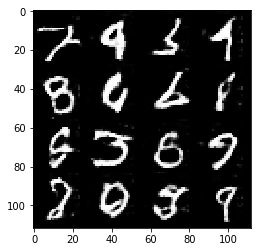

Epoch 1: Step:1700 d_loss:1.8851008415222168 g_loss:0.2836763262748718
Epoch 1: Step:1750 d_loss:1.344468355178833 g_loss:0.6426111459732056
Epoch 1: Step:1800 d_loss:1.5725624561309814 g_loss:0.4275585412979126


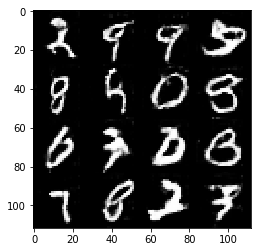

Epoch 1: Step:1850 d_loss:1.168198585510254 g_loss:0.7331984043121338


In [74]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0: Step:0 d_loss:10.607438087463379 g_loss:0.00025785266188904643


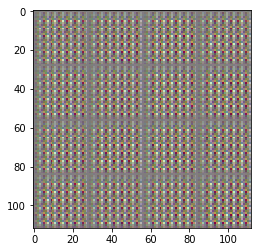

Epoch 0: Step:50 d_loss:2.1003293991088867 g_loss:0.5947628021240234
Epoch 0: Step:100 d_loss:2.0750536918640137 g_loss:0.2223338782787323
Epoch 0: Step:150 d_loss:1.7448152303695679 g_loss:0.6453195214271545


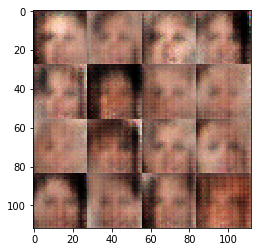

Epoch 0: Step:200 d_loss:1.7295153141021729 g_loss:0.4554252326488495
Epoch 0: Step:250 d_loss:1.946315884590149 g_loss:0.4444817006587982
Epoch 0: Step:300 d_loss:1.7664644718170166 g_loss:0.5256102085113525


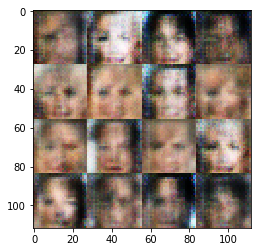

Epoch 0: Step:350 d_loss:2.0286664962768555 g_loss:0.48588985204696655
Epoch 0: Step:400 d_loss:1.804443597793579 g_loss:0.472206711769104
Epoch 0: Step:450 d_loss:1.7038567066192627 g_loss:0.6310027837753296


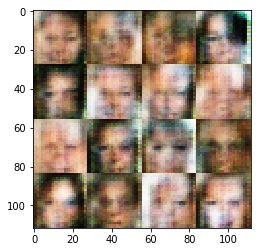

Epoch 0: Step:500 d_loss:1.7277390956878662 g_loss:0.6336168646812439
Epoch 0: Step:550 d_loss:1.638352632522583 g_loss:0.5894083380699158
Epoch 0: Step:600 d_loss:1.6443859338760376 g_loss:0.6004390120506287


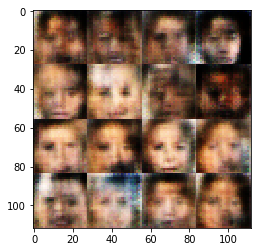

Epoch 0: Step:650 d_loss:1.6894444227218628 g_loss:0.5757336020469666
Epoch 0: Step:700 d_loss:1.8848998546600342 g_loss:0.5139834880828857
Epoch 0: Step:750 d_loss:1.6851646900177002 g_loss:0.7262914180755615


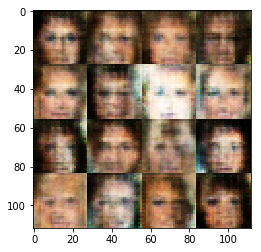

Epoch 0: Step:800 d_loss:1.493098497390747 g_loss:0.694882333278656
Epoch 0: Step:850 d_loss:1.5890512466430664 g_loss:0.669503927230835
Epoch 0: Step:900 d_loss:1.3530857563018799 g_loss:0.9639455676078796


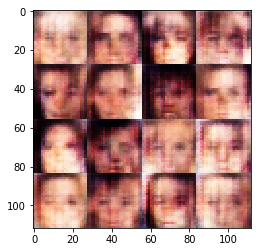

Epoch 0: Step:950 d_loss:1.410067081451416 g_loss:0.6666395664215088
Epoch 0: Step:1000 d_loss:1.514013648033142 g_loss:0.6767199039459229
Epoch 0: Step:1050 d_loss:1.7628740072250366 g_loss:0.5408024787902832


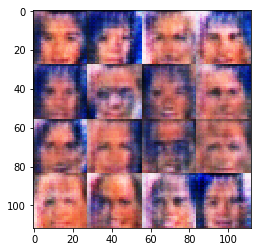

Epoch 0: Step:1100 d_loss:1.6992247104644775 g_loss:0.5329501032829285
Epoch 0: Step:1150 d_loss:1.459262490272522 g_loss:0.8143401145935059
Epoch 0: Step:1200 d_loss:1.393953800201416 g_loss:0.6830729246139526


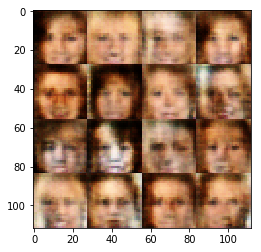

Epoch 0: Step:1250 d_loss:1.80976140499115 g_loss:0.5903319716453552
Epoch 0: Step:1300 d_loss:1.656258225440979 g_loss:0.87587571144104
Epoch 0: Step:1350 d_loss:2.5487704277038574 g_loss:0.32294073700904846


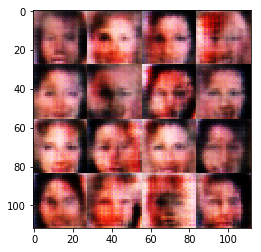

Epoch 0: Step:1400 d_loss:1.336516261100769 g_loss:0.8432303071022034
Epoch 0: Step:1450 d_loss:1.4937593936920166 g_loss:0.6881980895996094
Epoch 0: Step:1500 d_loss:1.4741787910461426 g_loss:0.6987916231155396


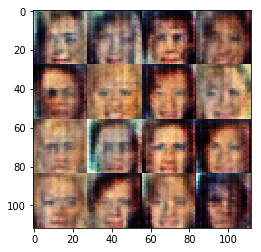

Epoch 0: Step:1550 d_loss:1.4154096841812134 g_loss:0.7722710371017456
Epoch 0: Step:1600 d_loss:1.592085599899292 g_loss:0.5956894159317017
Epoch 0: Step:1650 d_loss:1.56067955493927 g_loss:0.7016168832778931


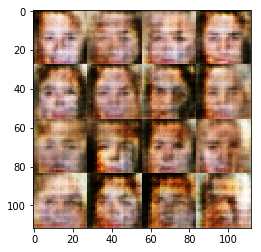

Epoch 0: Step:1700 d_loss:1.8059837818145752 g_loss:0.651081919670105
Epoch 0: Step:1750 d_loss:1.5417543649673462 g_loss:0.6342766284942627
Epoch 0: Step:1800 d_loss:1.5775573253631592 g_loss:0.6739906072616577


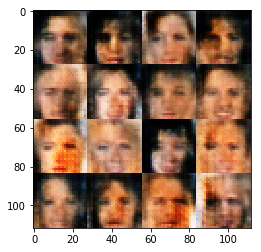

Epoch 0: Step:1850 d_loss:1.51261568069458 g_loss:0.6296553015708923
Epoch 0: Step:1900 d_loss:1.422996163368225 g_loss:0.7258829474449158
Epoch 0: Step:1950 d_loss:1.7542929649353027 g_loss:0.4829022288322449


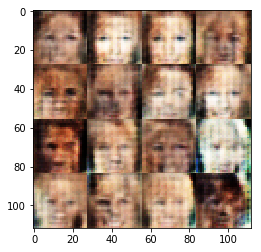

Epoch 0: Step:2000 d_loss:1.5059685707092285 g_loss:0.6490229368209839
Epoch 0: Step:2050 d_loss:1.4484591484069824 g_loss:0.8090869188308716
Epoch 0: Step:2100 d_loss:1.416418194770813 g_loss:0.6658986806869507


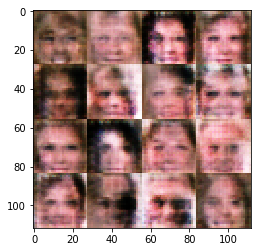

Epoch 0: Step:2150 d_loss:1.4681358337402344 g_loss:0.76012122631073
Epoch 0: Step:2200 d_loss:1.4152735471725464 g_loss:0.7928963899612427
Epoch 0: Step:2250 d_loss:1.629805564880371 g_loss:0.6891160011291504


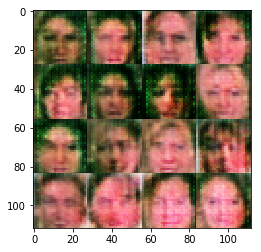

Epoch 0: Step:2300 d_loss:1.4814716577529907 g_loss:0.6461998224258423
Epoch 0: Step:2350 d_loss:1.3697954416275024 g_loss:0.7991592288017273
Epoch 0: Step:2400 d_loss:1.4833585023880005 g_loss:0.7040693759918213


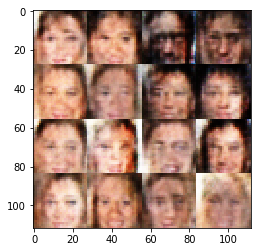

Epoch 0: Step:2450 d_loss:1.4510319232940674 g_loss:0.6858005523681641
Epoch 0: Step:2500 d_loss:1.477748990058899 g_loss:0.6857832670211792
Epoch 0: Step:2550 d_loss:1.7436641454696655 g_loss:0.5636813640594482


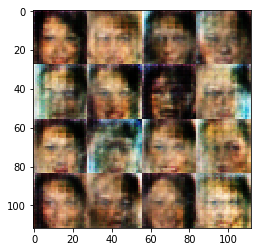

Epoch 0: Step:2600 d_loss:1.6241908073425293 g_loss:0.6809241771697998
Epoch 0: Step:2650 d_loss:1.425641417503357 g_loss:0.801558256149292
Epoch 0: Step:2700 d_loss:1.4749666452407837 g_loss:0.7280489206314087


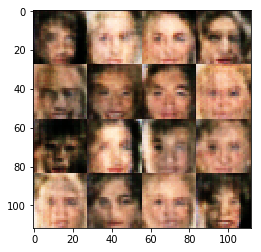

Epoch 0: Step:2750 d_loss:1.5166274309158325 g_loss:0.6320557594299316
Epoch 0: Step:2800 d_loss:1.6649067401885986 g_loss:0.5557845830917358
Epoch 0: Step:2850 d_loss:1.4080663919448853 g_loss:0.6722629070281982


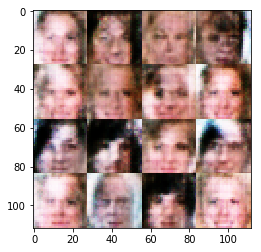

Epoch 0: Step:2900 d_loss:1.6671433448791504 g_loss:0.6326960325241089
Epoch 0: Step:2950 d_loss:1.4944967031478882 g_loss:0.7276065945625305
Epoch 0: Step:3000 d_loss:1.4416379928588867 g_loss:0.7038257122039795


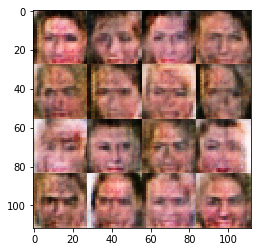

Epoch 0: Step:3050 d_loss:1.485121488571167 g_loss:0.708785891532898
Epoch 0: Step:3100 d_loss:1.335458755493164 g_loss:0.8066690564155579
Epoch 0: Step:3150 d_loss:1.7184820175170898 g_loss:0.6074676513671875


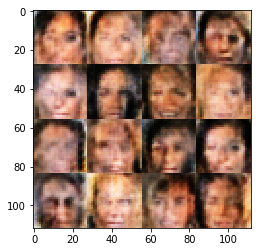

Epoch 0: Step:3200 d_loss:1.4147146940231323 g_loss:0.7410264015197754
Epoch 0: Step:3250 d_loss:1.5476031303405762 g_loss:0.7640910148620605
Epoch 0: Step:3300 d_loss:1.4973499774932861 g_loss:0.7012839317321777


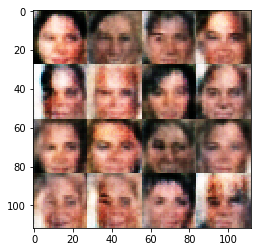

Epoch 0: Step:3350 d_loss:1.5289528369903564 g_loss:0.6501768827438354
Epoch 0: Step:3400 d_loss:1.3869590759277344 g_loss:0.7826306819915771
Epoch 0: Step:3450 d_loss:1.5242782831192017 g_loss:0.6559598445892334


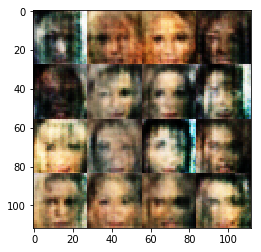

Epoch 0: Step:3500 d_loss:1.4941308498382568 g_loss:0.7785466909408569
Epoch 0: Step:3550 d_loss:1.4238903522491455 g_loss:0.884811282157898
Epoch 0: Step:3600 d_loss:1.445986032485962 g_loss:0.7581866383552551


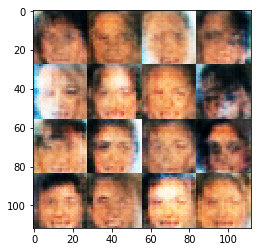

Epoch 0: Step:3650 d_loss:1.5469658374786377 g_loss:0.6732571125030518
Epoch 0: Step:3700 d_loss:1.4119300842285156 g_loss:0.7708622813224792
Epoch 0: Step:3750 d_loss:1.4201056957244873 g_loss:0.7158936262130737


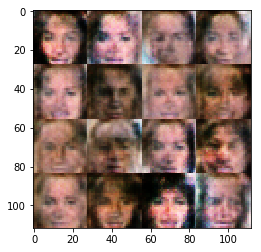

Epoch 0: Step:3800 d_loss:1.5039372444152832 g_loss:0.7673677206039429
Epoch 0: Step:3850 d_loss:1.4405672550201416 g_loss:0.6911083459854126
Epoch 0: Step:3900 d_loss:1.4050805568695068 g_loss:0.7224043607711792


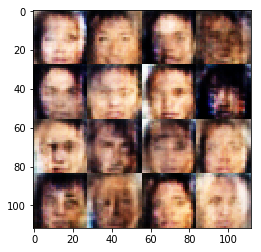

Epoch 0: Step:3950 d_loss:1.5068202018737793 g_loss:0.7417875528335571
Epoch 0: Step:4000 d_loss:1.372847557067871 g_loss:0.8525826930999756
Epoch 0: Step:4050 d_loss:1.3614578247070312 g_loss:0.8105601072311401


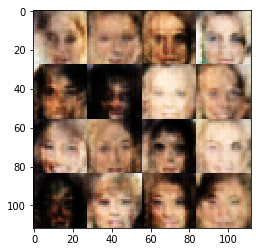

Epoch 0: Step:4100 d_loss:1.4661571979522705 g_loss:0.6927540302276611
Epoch 0: Step:4150 d_loss:1.3835508823394775 g_loss:0.7648454308509827
Epoch 0: Step:4200 d_loss:1.44267737865448 g_loss:0.6992117762565613


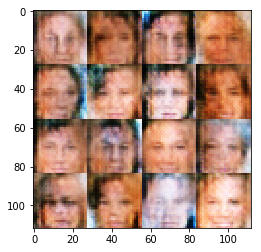

Epoch 0: Step:4250 d_loss:1.4587371349334717 g_loss:0.7630764245986938
Epoch 0: Step:4300 d_loss:1.4171017408370972 g_loss:0.7717349529266357
Epoch 0: Step:4350 d_loss:1.4550036191940308 g_loss:0.7437801361083984


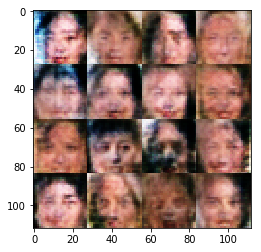

Epoch 0: Step:4400 d_loss:1.5402839183807373 g_loss:0.678349494934082
Epoch 0: Step:4450 d_loss:1.455620527267456 g_loss:0.7229245901107788
Epoch 0: Step:4500 d_loss:1.4544579982757568 g_loss:0.7610375285148621


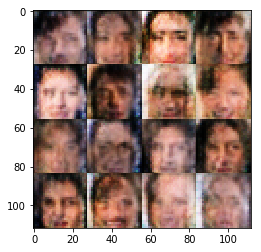

Epoch 0: Step:4550 d_loss:1.3606667518615723 g_loss:0.7785946130752563
Epoch 0: Step:4600 d_loss:1.363799810409546 g_loss:0.8534544706344604
Epoch 0: Step:4650 d_loss:1.4293137788772583 g_loss:0.7784716486930847


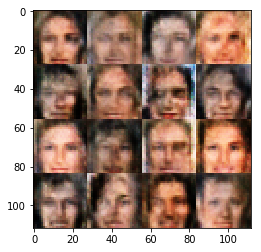

Epoch 0: Step:4700 d_loss:1.4175573587417603 g_loss:0.7541102170944214
Epoch 0: Step:4750 d_loss:1.4002048969268799 g_loss:0.746872067451477
Epoch 0: Step:4800 d_loss:1.43570077419281 g_loss:0.7360193729400635


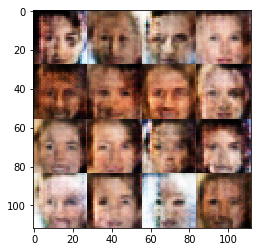

Epoch 0: Step:4850 d_loss:1.4259769916534424 g_loss:0.7033931612968445
Epoch 0: Step:4900 d_loss:1.438889503479004 g_loss:0.7218731641769409
Epoch 0: Step:4950 d_loss:1.428098201751709 g_loss:0.7708619832992554


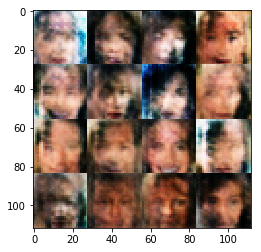

Epoch 0: Step:5000 d_loss:1.382338047027588 g_loss:0.7557284832000732
Epoch 0: Step:5050 d_loss:1.4171022176742554 g_loss:0.787372350692749
Epoch 0: Step:5100 d_loss:1.3758265972137451 g_loss:0.7735912799835205


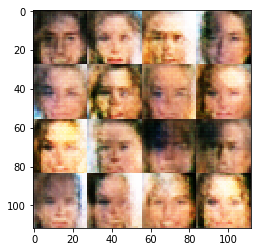

Epoch 0: Step:5150 d_loss:1.3679481744766235 g_loss:0.7964597940444946
Epoch 0: Step:5200 d_loss:1.4435241222381592 g_loss:0.7410663366317749
Epoch 0: Step:5250 d_loss:1.418461561203003 g_loss:0.734065592288971


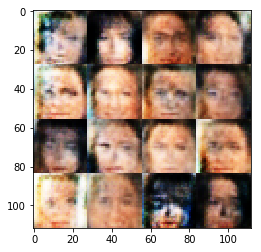

Epoch 0: Step:5300 d_loss:1.3736821413040161 g_loss:0.8074024319648743
Epoch 0: Step:5350 d_loss:1.4053422212600708 g_loss:0.7866217494010925
Epoch 0: Step:5400 d_loss:1.352534294128418 g_loss:0.8066720962524414


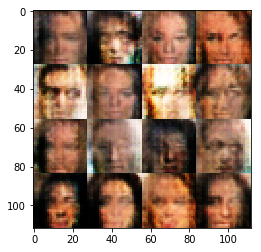

Epoch 0: Step:5450 d_loss:1.3590079545974731 g_loss:0.7888209819793701
Epoch 0: Step:5500 d_loss:1.4285808801651 g_loss:0.751940906047821
Epoch 0: Step:5550 d_loss:1.4136790037155151 g_loss:0.7704874277114868


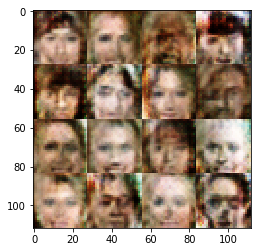

Epoch 0: Step:5600 d_loss:1.379758596420288 g_loss:0.8184372782707214
Epoch 0: Step:5650 d_loss:1.430521011352539 g_loss:0.7390114068984985
Epoch 0: Step:5700 d_loss:1.465881586074829 g_loss:0.7275956869125366


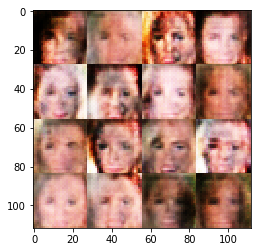

Epoch 0: Step:5750 d_loss:1.412994384765625 g_loss:0.7467878460884094
Epoch 0: Step:5800 d_loss:1.3565194606781006 g_loss:0.7863386273384094
Epoch 0: Step:5850 d_loss:1.4394316673278809 g_loss:0.7559460401535034


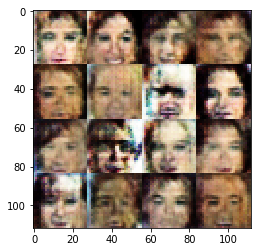

Epoch 0: Step:5900 d_loss:1.3919143676757812 g_loss:0.7692087888717651
Epoch 0: Step:5950 d_loss:1.4408073425292969 g_loss:0.7167867422103882
Epoch 0: Step:6000 d_loss:1.3773952722549438 g_loss:0.7663666009902954


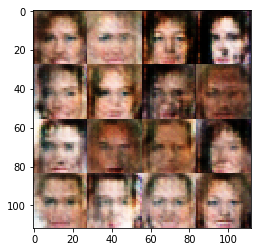

Epoch 0: Step:6050 d_loss:1.4270849227905273 g_loss:0.7949504852294922
Epoch 0: Step:6100 d_loss:1.4302468299865723 g_loss:0.771933913230896
Epoch 0: Step:6150 d_loss:1.3677804470062256 g_loss:0.7681538462638855


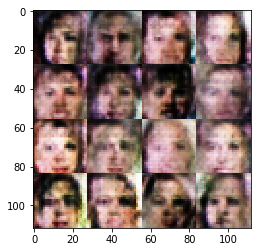

Epoch 0: Step:6200 d_loss:1.390700101852417 g_loss:0.7745734453201294
Epoch 0: Step:6250 d_loss:1.4017431735992432 g_loss:0.7728030681610107
Epoch 0: Step:6300 d_loss:1.4043693542480469 g_loss:0.7638454437255859


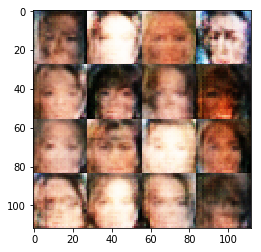

In [81]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 0: Step:0 d_loss:8.883585929870605 g_loss:0.0007345388294197619


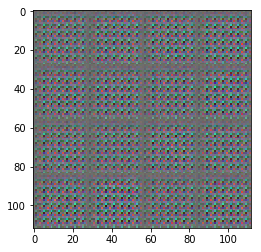

Epoch 0: Step:50 d_loss:3.3144123554229736 g_loss:0.15315252542495728
Epoch 0: Step:100 d_loss:1.645707130432129 g_loss:0.6781166791915894
Epoch 0: Step:150 d_loss:2.099165439605713 g_loss:0.35737326741218567


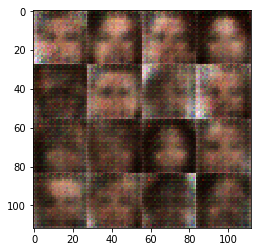

Epoch 0: Step:200 d_loss:1.3279359340667725 g_loss:0.7818677425384521
Epoch 0: Step:250 d_loss:1.284972906112671 g_loss:0.8077306747436523
Epoch 0: Step:300 d_loss:1.5462472438812256 g_loss:0.8686747550964355


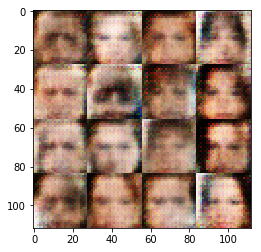

Epoch 0: Step:350 d_loss:1.7443900108337402 g_loss:0.5578610897064209
Epoch 0: Step:400 d_loss:1.6409497261047363 g_loss:0.6894281506538391
Epoch 0: Step:450 d_loss:1.5261446237564087 g_loss:0.6654461622238159


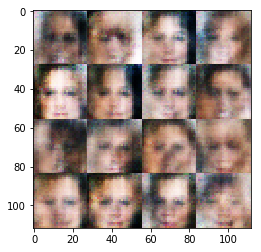

Epoch 0: Step:500 d_loss:1.6655704975128174 g_loss:0.7092524170875549
Epoch 0: Step:550 d_loss:1.6357464790344238 g_loss:0.5567306280136108
Epoch 0: Step:600 d_loss:1.5370252132415771 g_loss:0.6827482581138611


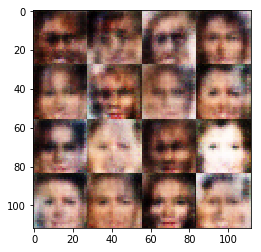

Epoch 0: Step:650 d_loss:1.4498237371444702 g_loss:0.7264412641525269
Epoch 0: Step:700 d_loss:2.0495710372924805 g_loss:0.5105375051498413
Epoch 0: Step:750 d_loss:1.4914593696594238 g_loss:0.6567810773849487


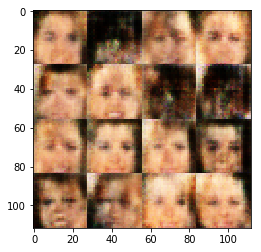

Epoch 0: Step:800 d_loss:1.6219096183776855 g_loss:0.6411730051040649
Epoch 0: Step:850 d_loss:1.4905991554260254 g_loss:0.6881287097930908
Epoch 0: Step:900 d_loss:1.696225881576538 g_loss:0.6144756078720093


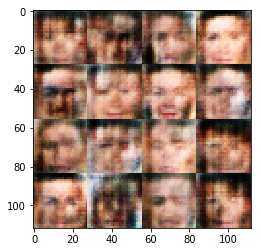

Epoch 0: Step:950 d_loss:1.3794364929199219 g_loss:0.6862510442733765
Epoch 0: Step:1000 d_loss:1.5628639459609985 g_loss:0.6331018209457397
Epoch 0: Step:1050 d_loss:1.6715583801269531 g_loss:0.586725652217865


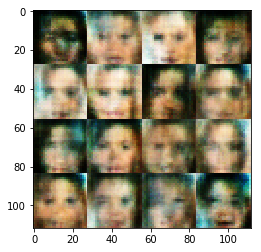

Epoch 0: Step:1100 d_loss:1.4611551761627197 g_loss:0.6583926677703857
Epoch 0: Step:1150 d_loss:1.42159104347229 g_loss:0.8247007131576538
Epoch 0: Step:1200 d_loss:1.9667590856552124 g_loss:0.46523600816726685


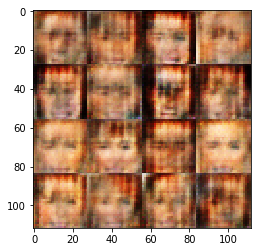

Epoch 0: Step:1250 d_loss:1.5337432622909546 g_loss:0.709546685218811
Epoch 0: Step:1300 d_loss:1.6615484952926636 g_loss:0.6233059167861938
Epoch 0: Step:1350 d_loss:1.3515937328338623 g_loss:0.8365979194641113


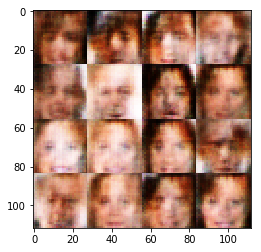

Epoch 0: Step:1400 d_loss:1.4848591089248657 g_loss:0.6600364446640015
Epoch 0: Step:1450 d_loss:1.4607973098754883 g_loss:0.7449999451637268
Epoch 0: Step:1500 d_loss:1.546858787536621 g_loss:0.6263312101364136


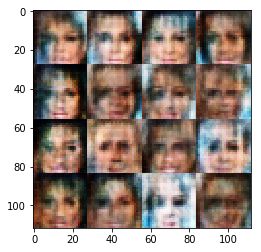

Epoch 0: Step:1550 d_loss:1.6467058658599854 g_loss:0.654616117477417
Epoch 0: Step:1600 d_loss:1.475534200668335 g_loss:0.8635588884353638
Epoch 0: Step:1650 d_loss:1.3990428447723389 g_loss:0.745185911655426


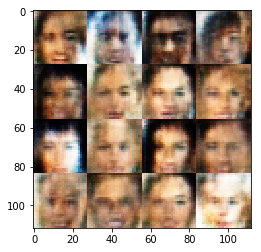

Epoch 0: Step:1700 d_loss:1.4507105350494385 g_loss:0.7499004602432251
Epoch 0: Step:1750 d_loss:1.538630723953247 g_loss:0.6521587371826172
Epoch 0: Step:1800 d_loss:1.5367374420166016 g_loss:0.7485393285751343


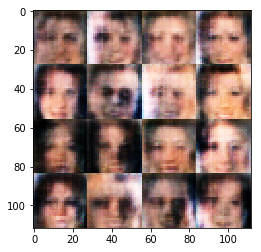

Epoch 0: Step:1850 d_loss:1.6711175441741943 g_loss:0.5248836278915405
Epoch 0: Step:1900 d_loss:1.7794699668884277 g_loss:0.6843003034591675
Epoch 0: Step:1950 d_loss:1.4163928031921387 g_loss:0.8182313442230225


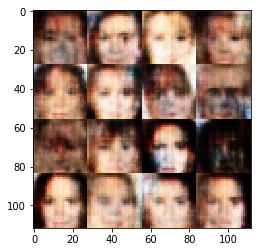

Epoch 0: Step:2000 d_loss:1.502150058746338 g_loss:0.6551973819732666
Epoch 0: Step:2050 d_loss:1.4045114517211914 g_loss:0.6590672135353088
Epoch 0: Step:2100 d_loss:1.451127290725708 g_loss:0.6319104433059692


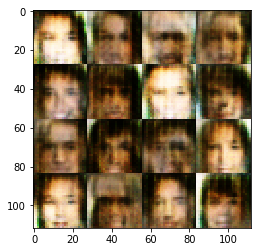

Epoch 0: Step:2150 d_loss:1.452959656715393 g_loss:0.7995902299880981
Epoch 0: Step:2200 d_loss:1.1079704761505127 g_loss:2.4916892051696777
Epoch 0: Step:2250 d_loss:1.4193209409713745 g_loss:0.8347986936569214


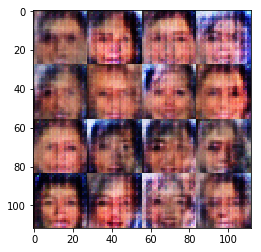

Epoch 0: Step:2300 d_loss:1.5071935653686523 g_loss:0.7511613368988037
Epoch 0: Step:2350 d_loss:1.629428744316101 g_loss:0.6612998843193054
Epoch 0: Step:2400 d_loss:1.4898419380187988 g_loss:0.6758561134338379


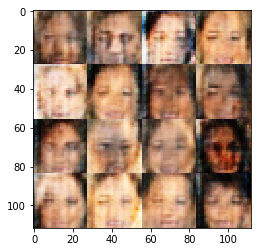

Epoch 0: Step:2450 d_loss:1.4306169748306274 g_loss:0.7446869611740112
Epoch 0: Step:2500 d_loss:1.4049351215362549 g_loss:0.7529600858688354
Epoch 0: Step:2550 d_loss:1.535517692565918 g_loss:0.6423923969268799


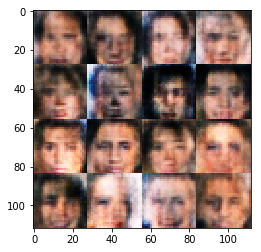

Epoch 0: Step:2600 d_loss:1.322799563407898 g_loss:0.833604097366333
Epoch 0: Step:2650 d_loss:1.4667285680770874 g_loss:0.7417020797729492
Epoch 0: Step:2700 d_loss:1.4275295734405518 g_loss:0.7920100688934326


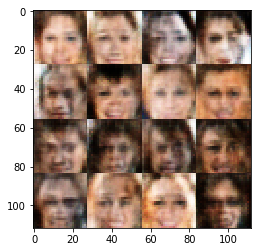

Epoch 0: Step:2750 d_loss:1.4436426162719727 g_loss:0.7197660803794861
Epoch 0: Step:2800 d_loss:1.5317392349243164 g_loss:0.6531926393508911
Epoch 0: Step:2850 d_loss:1.4684228897094727 g_loss:0.7162019610404968


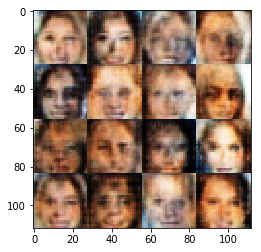

Epoch 0: Step:2900 d_loss:1.5121147632598877 g_loss:0.6821366548538208
Epoch 0: Step:2950 d_loss:1.3664557933807373 g_loss:0.7454526424407959
Epoch 0: Step:3000 d_loss:1.3778406381607056 g_loss:0.8018091320991516


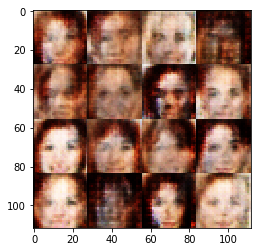

Epoch 0: Step:3050 d_loss:1.4066169261932373 g_loss:0.7864711880683899
Epoch 0: Step:3100 d_loss:1.4837186336517334 g_loss:0.8259193301200867
Epoch 0: Step:3150 d_loss:1.5262844562530518 g_loss:0.6310579776763916


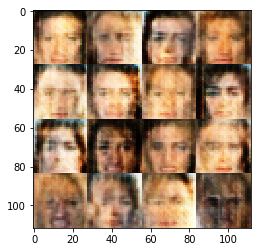

Epoch 0: Step:3200 d_loss:1.368371605873108 g_loss:0.7685843706130981
Epoch 0: Step:3250 d_loss:1.4340174198150635 g_loss:0.7497484087944031
Epoch 0: Step:3300 d_loss:1.499024510383606 g_loss:0.6144808530807495


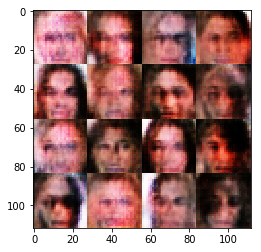

Epoch 0: Step:3350 d_loss:1.5787323713302612 g_loss:0.510857343673706
Epoch 0: Step:3400 d_loss:1.4184792041778564 g_loss:0.6892201900482178
Epoch 0: Step:3450 d_loss:1.5655031204223633 g_loss:0.6470526456832886


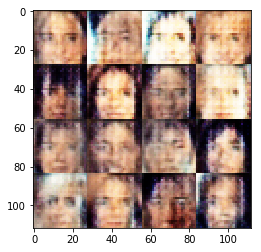

Epoch 0: Step:3500 d_loss:1.42244291305542 g_loss:0.7698657512664795
Epoch 0: Step:3550 d_loss:1.3971480131149292 g_loss:0.7873717546463013
Epoch 0: Step:3600 d_loss:1.5177711248397827 g_loss:0.7264832854270935


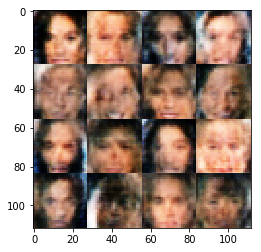

Epoch 0: Step:3650 d_loss:1.3862000703811646 g_loss:0.8010104894638062
Epoch 0: Step:3700 d_loss:1.4468187093734741 g_loss:0.7712700963020325
Epoch 0: Step:3750 d_loss:1.5244417190551758 g_loss:0.694189190864563


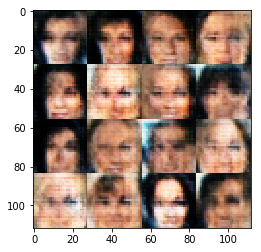

Epoch 0: Step:3800 d_loss:1.5554723739624023 g_loss:0.7280746102333069
Epoch 0: Step:3850 d_loss:1.4771056175231934 g_loss:0.7311558723449707
Epoch 0: Step:3900 d_loss:1.4508185386657715 g_loss:0.7657366991043091


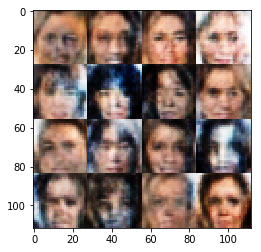

Epoch 0: Step:3950 d_loss:1.3928241729736328 g_loss:0.7849822044372559
Epoch 0: Step:4000 d_loss:1.4833815097808838 g_loss:0.7934662103652954
Epoch 0: Step:4050 d_loss:1.4201760292053223 g_loss:0.8676611185073853


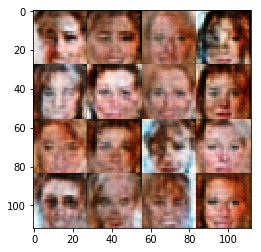

Epoch 0: Step:4100 d_loss:1.710954189300537 g_loss:0.5652086734771729
Epoch 0: Step:4150 d_loss:1.5460104942321777 g_loss:0.7807488441467285
Epoch 0: Step:4200 d_loss:1.3807419538497925 g_loss:0.8149179220199585


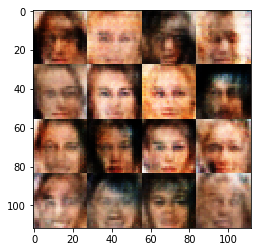

Epoch 0: Step:4250 d_loss:1.3877902030944824 g_loss:0.7181809544563293
Epoch 0: Step:4300 d_loss:1.3745946884155273 g_loss:0.7642077207565308
Epoch 0: Step:4350 d_loss:1.506547212600708 g_loss:0.7740645408630371


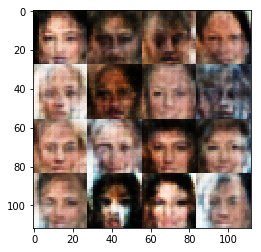

Epoch 0: Step:4400 d_loss:1.7376923561096191 g_loss:0.5370304584503174
Epoch 0: Step:4450 d_loss:1.4900097846984863 g_loss:0.7526474595069885
Epoch 0: Step:4500 d_loss:1.4566409587860107 g_loss:0.781333327293396


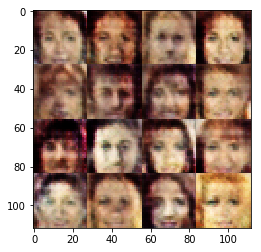

Epoch 0: Step:4550 d_loss:1.5246306657791138 g_loss:0.7316362857818604
Epoch 0: Step:4600 d_loss:1.509687900543213 g_loss:0.7030719518661499
Epoch 0: Step:4650 d_loss:1.553719401359558 g_loss:0.6040909290313721


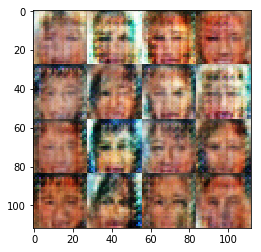

Epoch 0: Step:4700 d_loss:1.3941189050674438 g_loss:0.8471037149429321
Epoch 0: Step:4750 d_loss:1.4956490993499756 g_loss:0.8004722595214844
Epoch 0: Step:4800 d_loss:1.547302484512329 g_loss:0.6758244633674622


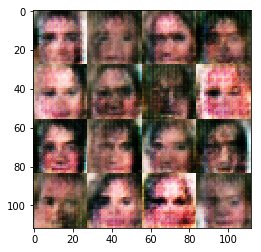

Epoch 0: Step:4850 d_loss:1.4532030820846558 g_loss:0.641353189945221
Epoch 0: Step:4900 d_loss:1.4560279846191406 g_loss:0.6665639877319336
Epoch 0: Step:4950 d_loss:1.4090297222137451 g_loss:0.7440935373306274


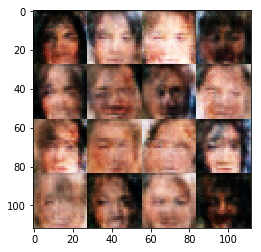

Epoch 0: Step:5000 d_loss:1.4129399061203003 g_loss:0.721101701259613
Epoch 0: Step:5050 d_loss:1.4361636638641357 g_loss:0.6997072100639343
Epoch 0: Step:5100 d_loss:1.4954814910888672 g_loss:0.6959514617919922


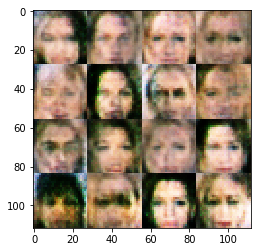

Epoch 0: Step:5150 d_loss:1.445988416671753 g_loss:0.7143641710281372
Epoch 0: Step:5200 d_loss:1.3742117881774902 g_loss:0.8429648876190186
Epoch 0: Step:5250 d_loss:1.393367052078247 g_loss:0.7313331365585327


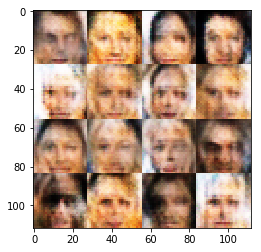

Epoch 0: Step:5300 d_loss:1.4406331777572632 g_loss:0.8141212463378906
Epoch 0: Step:5350 d_loss:1.4668042659759521 g_loss:0.7999089360237122
Epoch 0: Step:5400 d_loss:1.4392213821411133 g_loss:0.7331523895263672


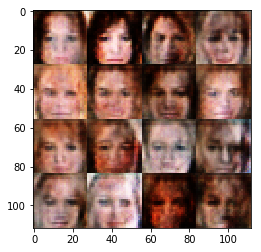

Epoch 0: Step:5450 d_loss:1.544230580329895 g_loss:0.6826308369636536
Epoch 0: Step:5500 d_loss:1.4194520711898804 g_loss:0.8839249610900879
Epoch 0: Step:5550 d_loss:1.398301601409912 g_loss:0.695480227470398


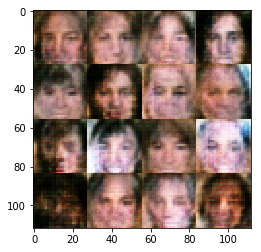

Epoch 0: Step:5600 d_loss:1.4322407245635986 g_loss:0.8456926345825195
Epoch 0: Step:5650 d_loss:1.3479677438735962 g_loss:0.7380564212799072
Epoch 0: Step:5700 d_loss:1.360819697380066 g_loss:0.8112746477127075


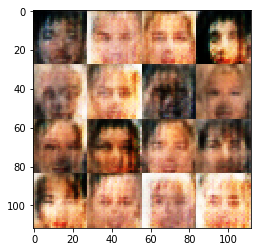

Epoch 0: Step:5750 d_loss:1.4291367530822754 g_loss:0.8481987714767456
Epoch 0: Step:5800 d_loss:1.4345102310180664 g_loss:0.747097909450531
Epoch 0: Step:5850 d_loss:1.391855001449585 g_loss:0.8030446767807007


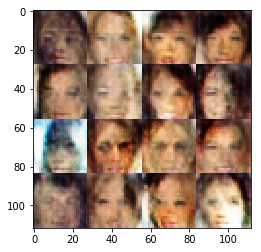

Epoch 0: Step:5900 d_loss:1.4130735397338867 g_loss:0.7175945043563843
Epoch 0: Step:5950 d_loss:1.4063282012939453 g_loss:0.8722485303878784
Epoch 0: Step:6000 d_loss:1.436915636062622 g_loss:0.6816419363021851


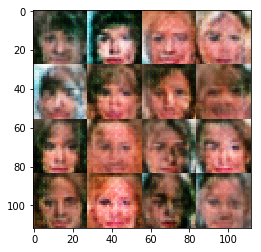

Epoch 0: Step:6050 d_loss:1.4129061698913574 g_loss:0.7665918469429016
Epoch 0: Step:6100 d_loss:1.3495813608169556 g_loss:0.8365975618362427
Epoch 0: Step:6150 d_loss:1.3982808589935303 g_loss:0.7440348863601685


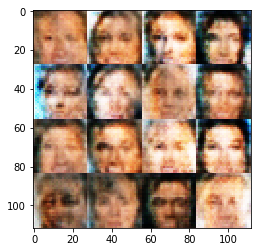

Epoch 0: Step:6200 d_loss:1.4032213687896729 g_loss:0.770110011100769
Epoch 0: Step:6250 d_loss:1.3529818058013916 g_loss:0.8218823075294495
Epoch 0: Step:6300 d_loss:1.3926116228103638 g_loss:0.7171969413757324


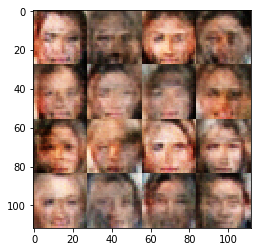

Epoch 1: Step:0 d_loss:1.3499504327774048 g_loss:0.8417298793792725


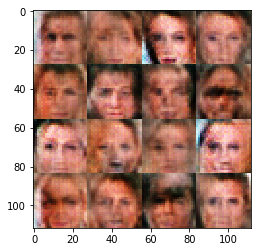

Epoch 1: Step:50 d_loss:1.4951233863830566 g_loss:0.7709197998046875
Epoch 1: Step:100 d_loss:1.4273282289505005 g_loss:0.7983912229537964
Epoch 1: Step:150 d_loss:1.4513704776763916 g_loss:0.741942822933197


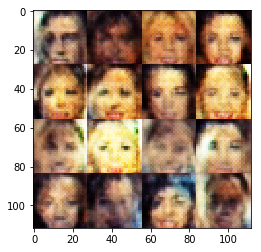

Epoch 1: Step:200 d_loss:1.5415546894073486 g_loss:0.6606644988059998
Epoch 1: Step:250 d_loss:1.5127625465393066 g_loss:0.7272061705589294
Epoch 1: Step:300 d_loss:1.4256319999694824 g_loss:0.7620729207992554


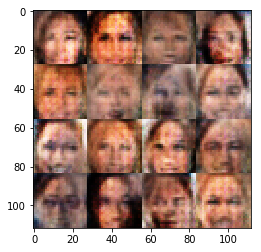

Epoch 1: Step:350 d_loss:1.5559207201004028 g_loss:0.7293367385864258
Epoch 1: Step:400 d_loss:1.3890167474746704 g_loss:0.7500796318054199
Epoch 1: Step:450 d_loss:1.387037992477417 g_loss:0.7384893894195557


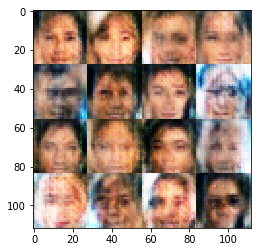

Epoch 1: Step:500 d_loss:1.4111530780792236 g_loss:0.7738584280014038
Epoch 1: Step:550 d_loss:1.3737566471099854 g_loss:0.8081587553024292
Epoch 1: Step:600 d_loss:1.4307661056518555 g_loss:0.8268904089927673


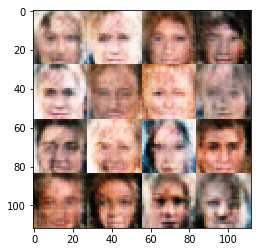

Epoch 1: Step:650 d_loss:1.3648890256881714 g_loss:0.8475391864776611
Epoch 1: Step:700 d_loss:1.429429531097412 g_loss:0.733080267906189
Epoch 1: Step:750 d_loss:1.4826864004135132 g_loss:0.6779860854148865


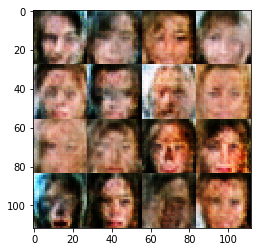

Epoch 1: Step:800 d_loss:1.3746395111083984 g_loss:0.767706036567688
Epoch 1: Step:850 d_loss:1.4387873411178589 g_loss:0.7909916043281555
Epoch 1: Step:900 d_loss:1.4349241256713867 g_loss:0.8597608804702759


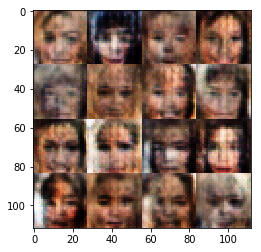

Epoch 1: Step:950 d_loss:1.4598150253295898 g_loss:0.6469796895980835
Epoch 1: Step:1000 d_loss:1.4818849563598633 g_loss:0.700129508972168
Epoch 1: Step:1050 d_loss:1.3925843238830566 g_loss:0.7791587114334106


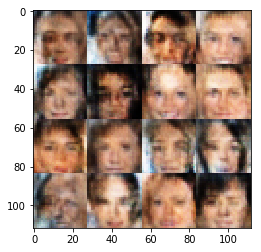

Epoch 1: Step:1100 d_loss:1.4455487728118896 g_loss:0.7339199781417847
Epoch 1: Step:1150 d_loss:1.394767165184021 g_loss:0.8075553178787231
Epoch 1: Step:1200 d_loss:1.441884160041809 g_loss:0.7959932088851929


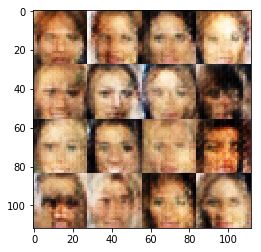

Epoch 1: Step:1250 d_loss:1.4982802867889404 g_loss:0.6998800039291382
Epoch 1: Step:1300 d_loss:1.564152479171753 g_loss:0.7007196545600891
Epoch 1: Step:1350 d_loss:1.4700086116790771 g_loss:0.7415399551391602


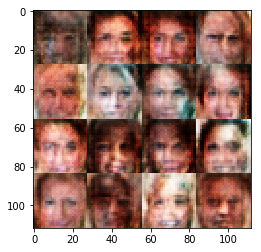

Epoch 1: Step:1400 d_loss:1.3717880249023438 g_loss:0.832915186882019
Epoch 1: Step:1450 d_loss:1.3990249633789062 g_loss:0.7517012357711792
Epoch 1: Step:1500 d_loss:1.4614415168762207 g_loss:0.7051082849502563


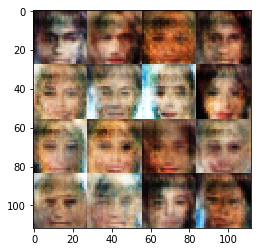

Epoch 1: Step:1550 d_loss:1.3697912693023682 g_loss:0.7965195178985596
Epoch 1: Step:1600 d_loss:1.403462290763855 g_loss:0.8088332414627075
Epoch 1: Step:1650 d_loss:1.4066163301467896 g_loss:0.8136153221130371


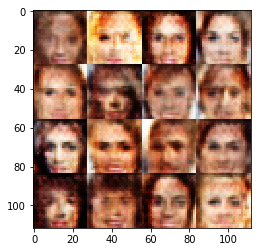

Epoch 1: Step:1700 d_loss:1.4919583797454834 g_loss:0.7068235874176025
Epoch 1: Step:1750 d_loss:1.4600969552993774 g_loss:0.6810506582260132
Epoch 1: Step:1800 d_loss:1.417958378791809 g_loss:0.7951937317848206


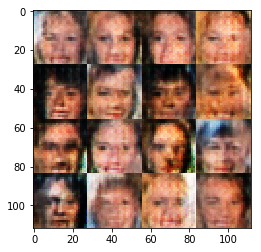

Epoch 1: Step:1850 d_loss:1.4036253690719604 g_loss:0.8191763162612915
Epoch 1: Step:1900 d_loss:1.4519176483154297 g_loss:0.7285441160202026
Epoch 1: Step:1950 d_loss:1.423374056816101 g_loss:0.7853353023529053


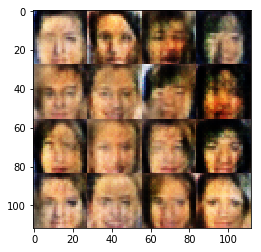

Epoch 1: Step:2000 d_loss:1.4520200490951538 g_loss:0.7770447731018066
Epoch 1: Step:2050 d_loss:1.4235706329345703 g_loss:0.7469596862792969
Epoch 1: Step:2100 d_loss:1.428710699081421 g_loss:0.8004900217056274


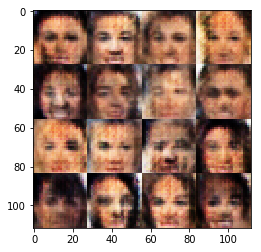

Epoch 1: Step:2150 d_loss:1.506999135017395 g_loss:0.6664424538612366
Epoch 1: Step:2200 d_loss:1.4118878841400146 g_loss:0.8152338266372681
Epoch 1: Step:2250 d_loss:1.393510341644287 g_loss:0.7795799374580383


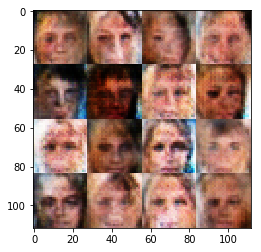

Epoch 1: Step:2300 d_loss:1.4691342115402222 g_loss:0.7200900316238403
Epoch 1: Step:2350 d_loss:1.5676605701446533 g_loss:0.69919353723526
Epoch 1: Step:2400 d_loss:1.4108054637908936 g_loss:0.7419203519821167


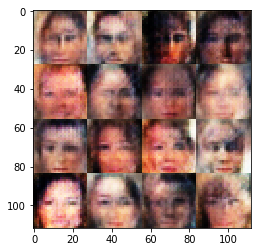

Epoch 1: Step:2450 d_loss:1.360095500946045 g_loss:0.81200110912323
Epoch 1: Step:2500 d_loss:1.402437686920166 g_loss:0.7683618068695068
Epoch 1: Step:2550 d_loss:1.404919147491455 g_loss:0.7824935913085938


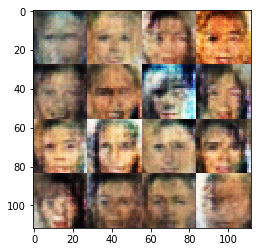

Epoch 1: Step:2600 d_loss:1.361939549446106 g_loss:0.775192141532898
Epoch 1: Step:2650 d_loss:1.370490312576294 g_loss:0.844992458820343
Epoch 1: Step:2700 d_loss:1.3992505073547363 g_loss:0.828488826751709


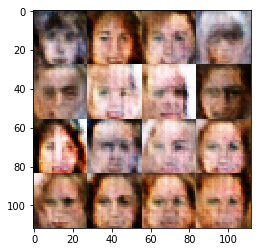

Epoch 1: Step:2750 d_loss:1.329599380493164 g_loss:0.81178218126297
Epoch 1: Step:2800 d_loss:1.4620931148529053 g_loss:0.7542760968208313
Epoch 1: Step:2850 d_loss:1.301822304725647 g_loss:0.851071298122406


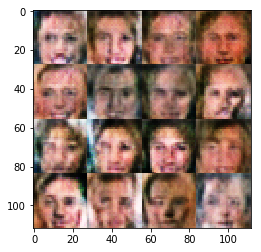

Epoch 1: Step:2900 d_loss:1.4427611827850342 g_loss:0.780785083770752
Epoch 1: Step:2950 d_loss:1.435347318649292 g_loss:0.7626000642776489
Epoch 1: Step:3000 d_loss:1.3132479190826416 g_loss:0.8229842782020569


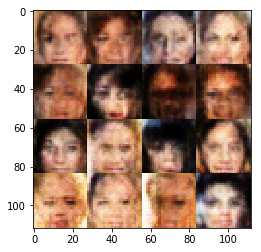

Epoch 1: Step:3050 d_loss:1.3690553903579712 g_loss:0.7567567825317383
Epoch 1: Step:3100 d_loss:1.4221947193145752 g_loss:0.746362566947937
Epoch 1: Step:3150 d_loss:1.3544485569000244 g_loss:0.8127055168151855


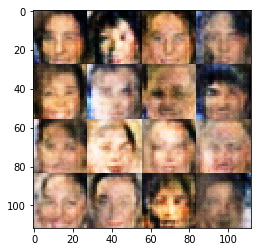

Epoch 1: Step:3200 d_loss:1.413642168045044 g_loss:0.7760525345802307
Epoch 1: Step:3250 d_loss:1.4061506986618042 g_loss:0.7831307649612427
Epoch 1: Step:3300 d_loss:1.3694851398468018 g_loss:0.7986382246017456


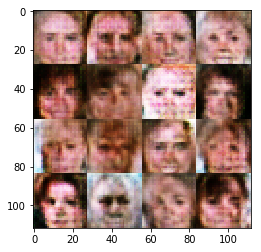

Epoch 1: Step:3350 d_loss:1.4314085245132446 g_loss:0.7330003976821899
Epoch 1: Step:3400 d_loss:1.4652011394500732 g_loss:0.8086527585983276
Epoch 1: Step:3450 d_loss:1.3554365634918213 g_loss:0.8133848905563354


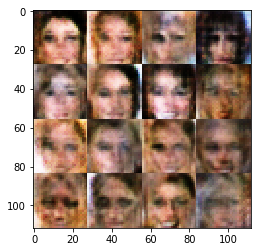

Epoch 1: Step:3500 d_loss:1.5158991813659668 g_loss:0.7326956987380981
Epoch 1: Step:3550 d_loss:1.3811084032058716 g_loss:0.7943817377090454
Epoch 1: Step:3600 d_loss:1.4328267574310303 g_loss:0.7491730451583862


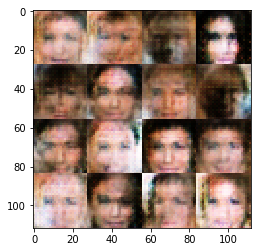

Epoch 1: Step:3650 d_loss:1.4193439483642578 g_loss:0.7453457713127136
Epoch 1: Step:3700 d_loss:1.3904094696044922 g_loss:0.7817129492759705
Epoch 1: Step:3750 d_loss:1.4198797941207886 g_loss:0.7601665258407593


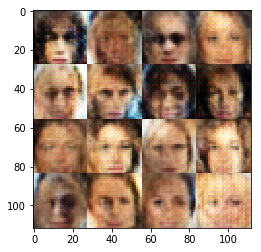

Epoch 1: Step:3800 d_loss:1.4054670333862305 g_loss:0.7928260564804077
Epoch 1: Step:3850 d_loss:1.4008206129074097 g_loss:0.6991569399833679
Epoch 1: Step:3900 d_loss:1.3830369710922241 g_loss:0.743285059928894


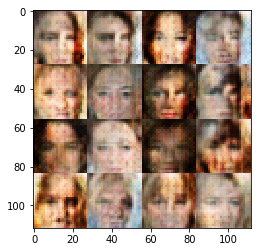

Epoch 1: Step:3950 d_loss:1.455627679824829 g_loss:0.7775039076805115
Epoch 1: Step:4000 d_loss:1.4072141647338867 g_loss:0.7600725293159485
Epoch 1: Step:4050 d_loss:1.3934433460235596 g_loss:0.7980773448944092


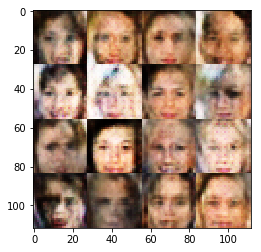

Epoch 1: Step:4100 d_loss:1.3920249938964844 g_loss:0.7968929409980774
Epoch 1: Step:4150 d_loss:1.4011019468307495 g_loss:0.7810994386672974
Epoch 1: Step:4200 d_loss:1.3093023300170898 g_loss:0.8034061193466187


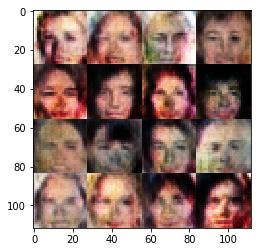

Epoch 1: Step:4250 d_loss:1.4108119010925293 g_loss:0.7710155248641968
Epoch 1: Step:4300 d_loss:1.414506196975708 g_loss:0.7768997550010681
Epoch 1: Step:4350 d_loss:1.332410216331482 g_loss:0.8734632134437561


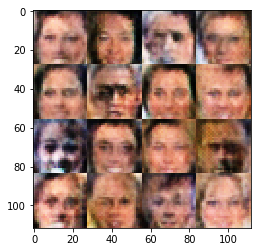

Epoch 1: Step:4400 d_loss:1.4218380451202393 g_loss:0.7522656321525574
Epoch 1: Step:4450 d_loss:1.4410836696624756 g_loss:0.8038290739059448
Epoch 1: Step:4500 d_loss:1.442726731300354 g_loss:0.7913172245025635


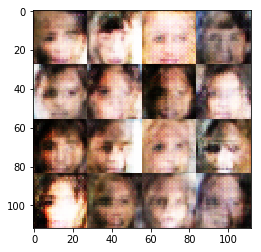

Epoch 1: Step:4550 d_loss:1.4953497648239136 g_loss:0.7475039958953857
Epoch 1: Step:4600 d_loss:1.3915632963180542 g_loss:0.7863146662712097
Epoch 1: Step:4650 d_loss:1.3457268476486206 g_loss:0.7948009371757507


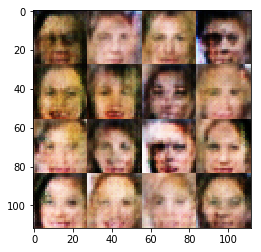

Epoch 1: Step:4700 d_loss:1.3751075267791748 g_loss:0.8129032850265503
Epoch 1: Step:4750 d_loss:1.3846263885498047 g_loss:0.7752865552902222
Epoch 1: Step:4800 d_loss:1.358145833015442 g_loss:0.7825052738189697


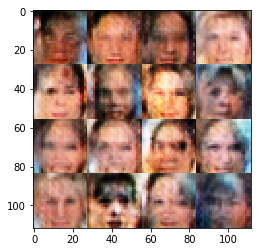

Epoch 1: Step:4850 d_loss:1.369699239730835 g_loss:0.7821893095970154
Epoch 1: Step:4900 d_loss:1.3600083589553833 g_loss:0.7839359641075134
Epoch 1: Step:4950 d_loss:1.3758938312530518 g_loss:0.7805899977684021


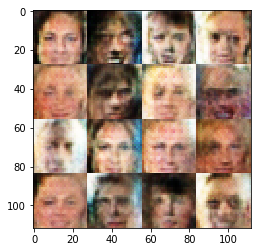

Epoch 1: Step:5000 d_loss:1.4539661407470703 g_loss:0.7373014092445374
Epoch 1: Step:5050 d_loss:1.4663500785827637 g_loss:0.7619980573654175
Epoch 1: Step:5100 d_loss:1.4445700645446777 g_loss:0.7235268354415894


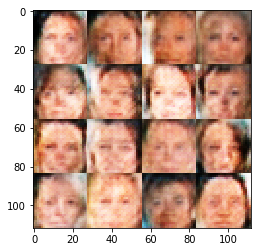

Epoch 1: Step:5150 d_loss:1.3770430088043213 g_loss:0.7824510335922241
Epoch 1: Step:5200 d_loss:1.413814663887024 g_loss:0.7802248597145081
Epoch 1: Step:5250 d_loss:1.315698504447937 g_loss:0.7585126161575317


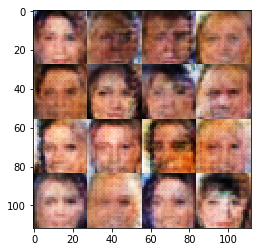

Epoch 1: Step:5300 d_loss:1.3651673793792725 g_loss:0.7921406030654907
Epoch 1: Step:5350 d_loss:1.3959438800811768 g_loss:0.7938582301139832
Epoch 1: Step:5400 d_loss:1.3789277076721191 g_loss:0.8010749220848083


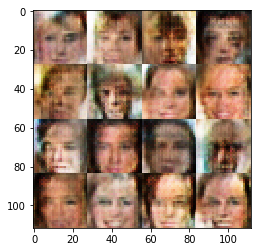

Epoch 1: Step:5450 d_loss:1.3516629934310913 g_loss:0.803045392036438
Epoch 1: Step:5500 d_loss:1.4287563562393188 g_loss:0.7449691295623779
Epoch 1: Step:5550 d_loss:1.343651533126831 g_loss:0.79112309217453


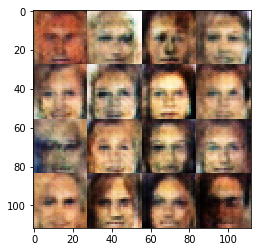

Epoch 1: Step:5600 d_loss:1.418027639389038 g_loss:0.7619626522064209
Epoch 1: Step:5650 d_loss:1.410321831703186 g_loss:0.7718503475189209
Epoch 1: Step:5700 d_loss:1.3867716789245605 g_loss:0.7618752717971802


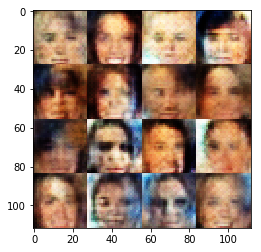

Epoch 1: Step:5750 d_loss:1.3701180219650269 g_loss:0.8072512149810791
Epoch 1: Step:5800 d_loss:1.3494353294372559 g_loss:0.8411420583724976
Epoch 1: Step:5850 d_loss:1.3877711296081543 g_loss:0.778638482093811


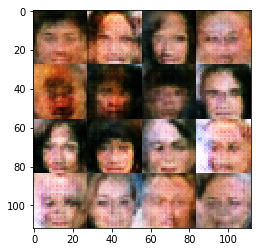

Epoch 1: Step:5900 d_loss:1.3825688362121582 g_loss:0.7784680128097534
Epoch 1: Step:5950 d_loss:1.4125036001205444 g_loss:0.7775090932846069
Epoch 1: Step:6000 d_loss:1.3973420858383179 g_loss:0.7606256604194641


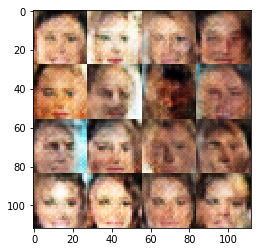

Epoch 1: Step:6050 d_loss:1.4012141227722168 g_loss:0.7801791429519653
Epoch 1: Step:6100 d_loss:1.4140517711639404 g_loss:0.7983113527297974
Epoch 1: Step:6150 d_loss:1.351944088935852 g_loss:0.7989935874938965


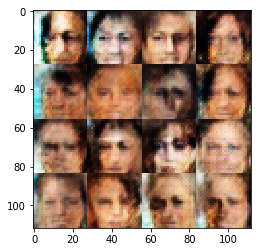

Epoch 1: Step:6200 d_loss:1.4570531845092773 g_loss:0.7219067811965942
Epoch 1: Step:6250 d_loss:1.3560638427734375 g_loss:0.807376503944397
Epoch 1: Step:6300 d_loss:1.3961677551269531 g_loss:0.7865221500396729


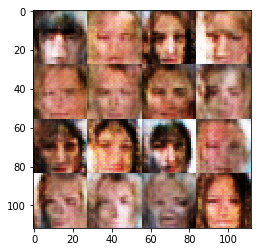

In [83]:
# for my own personal testing

batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.